# GAN Project

I'm not sure exactly what I want to call it yet, but the goal is to make a webapp that uses GANs and Deep Learning to remove artifacts on images the user uploads. I wanted to make this to get some experience working with GANs as I think their applications are endless and really intresting, along with doing some web development that I don't have a ton of experience in.

**TO-DO**
- Fix paths for where models are saved
- Add 'master' crappify function that does all PIL augmentation
- Create more 'realistic' PIL augmentation based off test images, and randomize artifact pacement for better generalization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.gan import *

from PIL import Image, ImageDraw, ImageFont
import string

In [3]:
torch.cuda.set_device(0)
print(f"Using GPU {torch.cuda.current_device()}")

Using GPU 0


Edit/uncomment as needed:

In [4]:
# Change for each artifact
artif_pre = "random_text"

# Gradual Resizing
bs,size = 32, 128
# bs,size = 24,160
# bs,size = 8,256

## Utility Functions

In [5]:
def get_data(bs,size):
    tfms = get_transforms(do_flip=False, max_rotate=5.0, max_zoom=1.05, max_warp=0)
    
    data = (src.label_from_func(lambda x: NORM/x.name)
           .transform(tfms, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [6]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                        self_attention=True, y_range=y_range, loss_func=loss_gen)

In [7]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(GEN/names[i].name)
            i += 1

In [8]:
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(PATH, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    tfms = get_transforms(do_flip=False, max_rotate=5.0, max_zoom=1.05, max_warp=0)
    data = (ll.transform(tfms, size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [9]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [10]:
def crappify(norm_src, crap_src):
    for x in os.listdir(norm_src):
        if x[-3:] != "png" and x[0] != ".":
            fn = x.split('.')[0]
            img = PIL.Image.open(norm_src/x).convert("RGBA")
            img.save(str(norm_src/fn) + ".png")
            os.system(f"rm {norm_src/x}")   
    
    for img in os.listdir(norm_src):
        img_path = str(norm_src/img)
        
        # Load image elements
        img = PIL.Image.open(img_path).convert("RGBA")
        w,h = img.size
        blank_img = Image.new('RGBA', img.size, (255,255,255,0))
        draw_blank = ImageDraw.Draw(blank_img)
        
        # List of Crappify functions to use
        c1 = draw_random_text(img, w, h, blank_img, draw_blank)
        
        # Save image
        file_name = img_path.split('/')[-1]
        c1.save(crap_src/file_name)

### Image Crappify Functions

In [11]:
def draw_random_text(img, w, h, blank_img, draw_blank):    
    # Font properties
    font_list = ["dejavu", "abyssinica", "tibetan-machine", "liberation2", "padauk", "Sahadeva", "ubuntu",
                 "fonts-gujr-extra", "fonts-beng-extra", "fonts-deva-extra", "malayalam", "freefont", "ttf-khmeros-core",
                 "pagul", "tlwg", "lohit-telugu", "lohit-devanagari", "Nakula", "Sarai", "lao", "Gargi",
                 "liberation"]
    text_sz = np.random.randint(50,100)
    text_len = np.random.randint(4,16)
    text_opct = np.random.randint(64,128)
    text_string = ''.join(random.choices(string.ascii_uppercase + string.ascii_lowercase + string.digits, k=text_len))
    tc = np.random.randint(100,200)

    # Select Font
    FONTS_PATH = Path("/usr/share/fonts/truetype/")
    FONT_PATH = Path(FONTS_PATH/np.random.choice(font_list))
    SUBFONT_PATH = str(Path(FONT_PATH/np.random.choice(os.listdir(FONT_PATH))))
    fnt = ImageFont.truetype(SUBFONT_PATH,text_sz)
    fw,fh = fnt.getsize(text_string)

    # Draw text
    draw_blank.text((w/2-fw/2,h/2-fh/2), text_string, font=fnt, align="center", fill=(tc,tc,tc,text_opct))
    
    out = Image.alpha_composite(img, blank_img)
    return out

## Data

I'll start by just focusing on training my GAN on portrait shots of people's faces. To get my dataset, I'll scrape Google Images to get a decent amount of Images, then create "crappy" versions of them from a custom function that my GAN will work on cleaning up and making close to the clean original.

In [12]:
# os.system("rm -rf data/gan_project/normal") # RESET 
# os.system("rm -rf data/gan_project/crappy") # RESET 

os.makedirs('data/gan_project/normal', exist_ok=True)
os.makedirs('data/gan_project/crappy', exist_ok=True)

PATH = Path('data/gan_project')
NORM = Path(PATH/'normal')
CRAP = Path(PATH/'crappy')

### Scraping Google Images

Downloading Images

In [ ]:
# os.system(f"touch {NORM}/image_urls.txt")
# file = "image_urls.txt"
file = "image_urls_2.txt"

In [ ]:
f = open(PATH/file, 'r')
test = str(f.read())

In [ ]:
amt = np.arange(0,999)

In [ ]:
os.system(f"touch {PATH}/{file[:-4]}_cleaned.txt")
cleaned_urls = open(f"{PATH}/{file[:-4]}_cleaned.txt", "w")
new_test = test.replace("\"", "")
for x in amt:
#     print(x)
    new_test = new_test.replace(f"\n{str(x)}:", "")

new_test = new_test.replace(" ", "\n")
new_test = new_test.replace("'0:\n'", "")
cleaned_urls.write(new_test)
cleaned_urls.close()

In [ ]:
file = "image_urls_2_cleaned.txt"

In [ ]:
download_images(PATH/file, NORM, max_pics=999)

Remove images that can't be opened

In [ ]:
verify_images(NORM, delete=True, max_size=500)

In [ ]:
len(os.listdir(NORM))

Convert images to PNG format

In [ ]:
%%time
os.system(f"rm {NORM}/*.webp")

for x in os.listdir(NORM):
    if x[-3:] != "png" and x[0] != ".":
        fn = x.split('.')[0]
        img = PIL.Image.open(NORM/x).convert("RGBA")
        img.save(str(NORM/fn) + ".png")
        os.system(f"rm {NORM/x}")

Upsampling Training Set (Exprimental)

In [ ]:
PATH

In [ ]:
# Setting a new path for our increased dataset
os.makedirs(f'{PATH}/large', exist_ok=True)
lrg_path = Path(f'{PATH}/large')

In [ ]:
# Restart
os.system(f'rm -rf {lrg_path}')
os.makedirs(lrg_path, exist_ok=True)
os.system(f'cp {NORM}/*.png {lrg_path}')

In [ ]:
amt_norm = os.listdir(NORM)

In [ ]:
%%time
datasets = {'normal':amt_norm}

for ds in datasets:
    
    amt = datasets[ds]
    amt_len = len(amt)
    mult_amt = 10
    i = 1

    while i < mult_amt:
        n = 0
        while n < amt_len:
            amt.append(amt[n][:-4] + '_copy_' + str(i) + '.png')
            os.system(f'cp {lrg_path}/{amt[n]} {lrg_path}/{amt[n][:-4]}_copy_{str(i)}.png')
            n+=1
        i+=1

In [ ]:
# Change depending on if using upscaled data or not
NORM = lrg_path

View Images

In [ ]:
il = ImageItemList.from_folder(NORM)

In [ ]:
il[:5]

In [ ]:
il[150]

### Crappifying Images

I'm stealing this term from Jeremy Howard's method of creating poor-quality images for a GAN to recreate. We need to think about what kind of artifacts are commonly seen in images for deciding how we want to "crappify" the high quality ones pulled from Google Images. Artifacts we may want to consider training the GAN for are:

- Transparent or opaque text
- Repeating pattens
- Low image resolution
- Color corrections

In [ ]:
%%time
# Only call once
crappify(NORM, CRAP)

In [ ]:
img_path = Path(NORM/os.listdir(NORM)[4])
img = PIL.Image.open(img_path).convert("RGBA")
w,h = img.size

blank_img = Image.new('RGBA', img.size, (255,255,255,0))
draw_blank = ImageDraw.Draw(blank_img)

# Test Different patterns below
FONTS_PATH = Path("/usr/share/fonts/truetype/")
FONT_PATH = Path(FONTS_PATH/os.listdir(FONTS_PATH)[4])
print(FONT_PATH)
print(os.listdir(FONT_PATH))

SUBFONT_PATH = str(Path(FONT_PATH/os.listdir(FONT_PATH)[0]))
fnt = ImageFont.truetype(SUBFONT_PATH,50)

print(fnt.getsize("SAMPLETEXT"))
fw,fh = fnt.getsize("SAMPLETEXT")
# fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 40)
draw_blank.text((w/2-fw/2,h/2-fh/2), "SAMPLETEXT", font=fnt, align="center", fill=(100,100,100,128))


out = Image.alpha_composite(img, blank_img)
out

In [ ]:
%%time
# Only call once
crappify(NORM, CRAP)

In [ ]:
il = ImageItemList.from_folder(NORM)
il_c = ImageItemList.from_folder(CRAP)

In [ ]:
il_c[122]

## Pretrain Generator

In [13]:
gc.collect()

40

In [14]:
arch = models.resnet34
src = ImageImageList.from_folder(CRAP).random_split_by_pct(0.1, seed=42)

In [15]:
%%time
data_gen = get_data(bs,size)

CPU times: user 2.82 s, sys: 39.5 ms, total: 2.86 s
Wall time: 764 ms


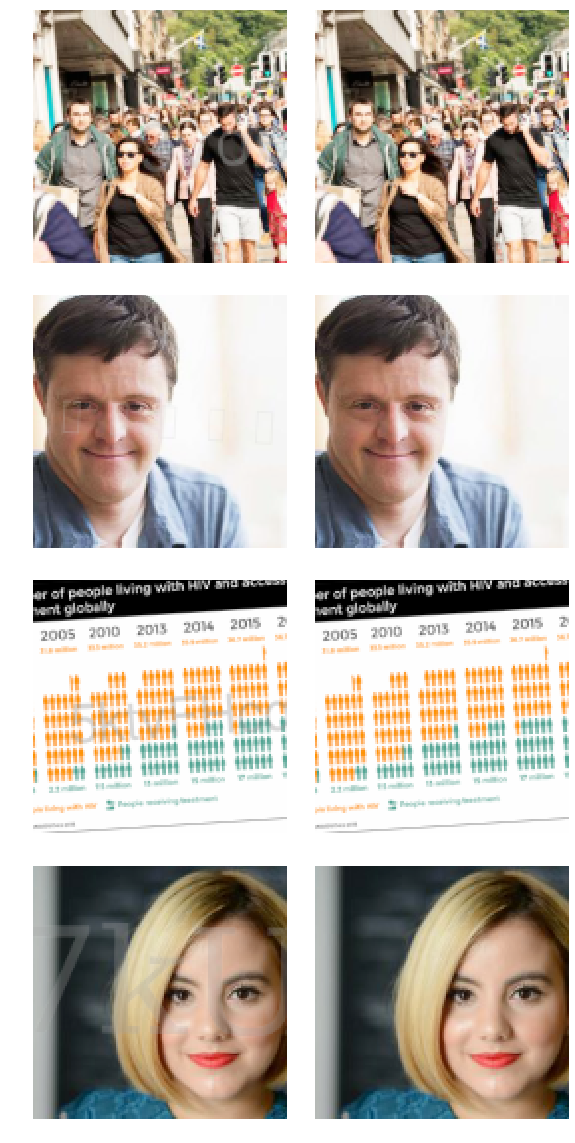

In [16]:
data_gen.show_batch(4)

In [17]:
wd = 1e-3

In [18]:
y_range = (-3., 3.)

In [19]:
loss_gen = MSELossFlat()

In [20]:
# ??create_gen_learner

In [21]:
%%time
learn_gen = create_gen_learner()
learn_gen.path = PATH/'models'

CPU times: user 48 s, sys: 761 ms, total: 48.8 s
Wall time: 3.72 s


In [22]:
# learn_gen.model

In [23]:
learn_gen.fit_one_cycle(40, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.992105,0.339103
2,0.546727,0.196044
3,0.347623,0.118719
4,0.232829,0.078376
5,0.161472,0.053429
6,0.114999,0.046744
7,0.083140,0.032529
8,0.061752,0.029847
9,0.048152,0.023886
10,0.038537,0.022446


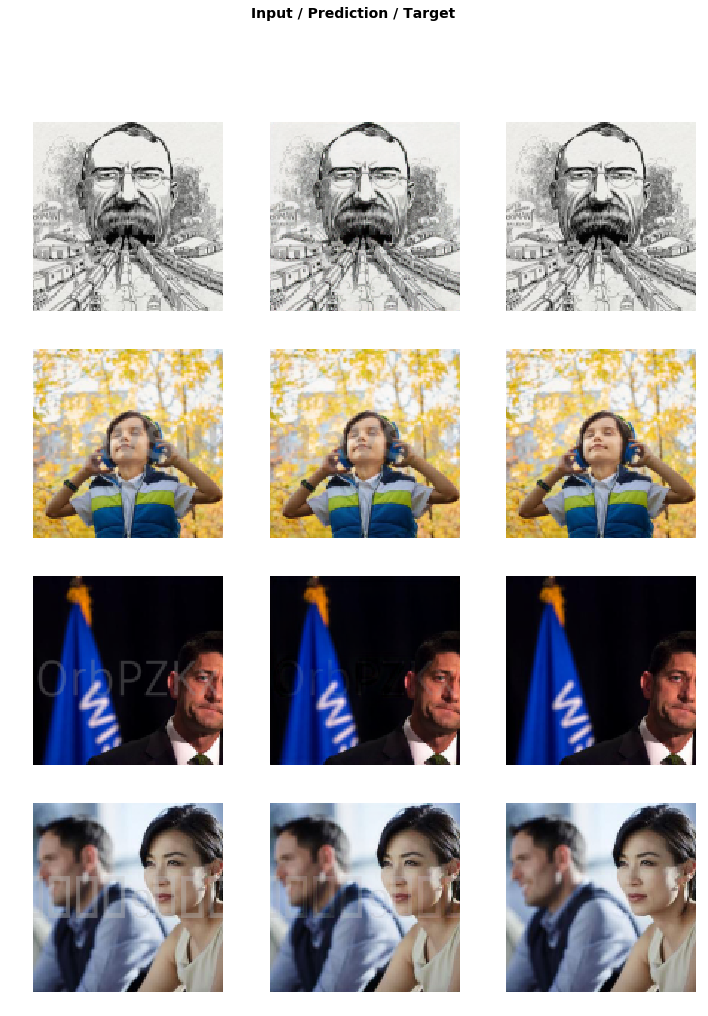

In [24]:
learn_gen.show_results(rows=4)

In [25]:
learn_gen.save(f'{artif_pre}_learn_gen')

### Save Generated Images

In [26]:
learn_gen.load(f'{artif_pre}_learn_gen');

In [27]:
name_gen = 'image_gen'
GEN = PATH/name_gen

In [28]:
GEN.mkdir(exist_ok=True)

In [29]:
save_preds(data_gen.fix_dl)

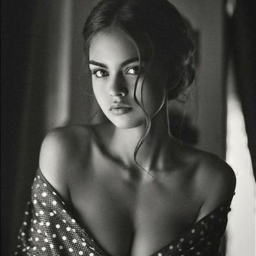

In [30]:
PIL.Image.open(GEN.ls()[1])

## Train Critic

In [31]:
learn_gen = None
gc.collect()

22729

Pretraining the critic on crappy vs non-crappy images

In [32]:
data_crit = get_crit_data([name_gen, 'normal'], bs=bs, size=size)

/home/waydegg/anaconda3/envs/fastai-course-v3/lib/python3.7/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your train set contained the folowing unknown labels, the corresponding items have been discarded.
gan_project
  if getattr(ds, 'warn', False): warn(ds.warn)


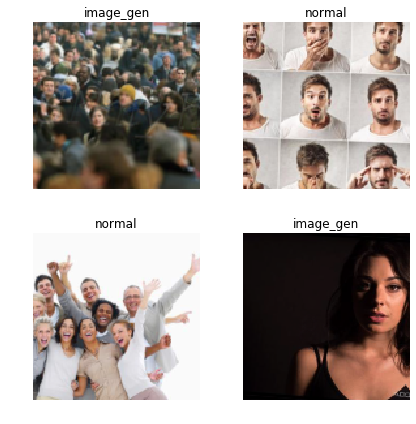

In [33]:
data_crit.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)

In [34]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [35]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [36]:
learn_critic.fit_one_cycle(24, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand
1,0.587880,0.518993,0.756024
2,0.584308,0.514760,0.754096
3,0.584624,0.527879,0.756024
4,0.569653,0.503571,0.752048
5,0.556799,0.545466,0.754699
6,0.547960,0.521114,0.760602
7,0.539179,0.517495,0.754578
8,0.538808,0.508583,0.754337
9,0.530386,0.543239,0.752289
10,0.516475,0.488542,0.765542


In [37]:
learn_critic.save(f'{artif_pre}_learn_critic')

## GAN

In [38]:
learn_crit = None
learn_gen = None
switcher = None
gc.collect()

7160

In [39]:
data_crit = get_crit_data(['crappy', 'normal'], bs=bs, size=size)

/home/waydegg/anaconda3/envs/fastai-course-v3/lib/python3.7/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your train set contained the folowing unknown labels, the corresponding items have been discarded.
gan_project
  if getattr(ds, 'warn', False): warn(ds.warn)


In [40]:
learn_crit = create_critic_learner(data_crit, metrics=None).load(f'{artif_pre}_learn_critic')

In [41]:
learn_gen = create_gen_learner().load(f'{artif_pre}_learn_gen')

Defining GAN Learner

In [42]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd, path=PATH/'models')
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [43]:
learn.path

PosixPath('data/gan_project/models')

In [44]:
lr = 1e-4

In [45]:
learn.fit(60, lr)

In [46]:
learn.save(f'{artif_pre}_gan_first')

In [47]:
gc.collect()
learn.load(f'{artif_pre}_gan_first');

Choosing your image size seems to be very limited at the moment, anything much higher than 200 pixels gives OOM errors regardless of batch size.

In [48]:
learn.data = get_data(8,256)

In [49]:
# Normally there would be a `get_data()` here to increase the resolution of
# the images being trained, which is why there's a second `learn.fit` below

In [50]:
learn.fit(40, lr/2)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [51]:
learn.save(f'{artif_pre}_gan_second')

In [77]:
gc.collect()
learn.load(f'{artif_pre}_gan_second');

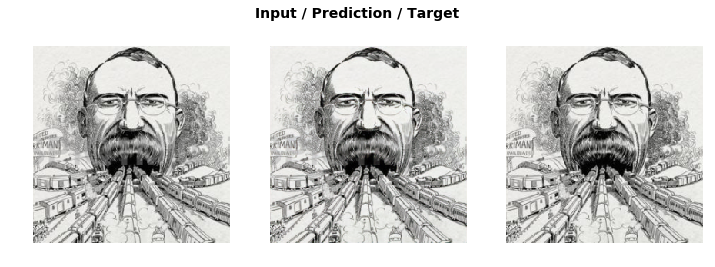

In [53]:
learn.show_results(rows=1)

In [66]:
learn.path

PosixPath('data/gan_project/models')

In [81]:
import dill as pickle

In [82]:
learn.export(fname = 'export_test.pkl')

AttributeError: Can't pickle local object 'gan_loss_from_func.<locals>._loss_G'

## Playground

In [69]:
PATH

PosixPath('data/gan_project')

In [70]:
test_pics = Path(PATH/'cool_pics'/'test_pics')
crap_test = Path(PATH/'cool_pics'/'crappy')

In [71]:
crappify(test_pics, crap_test)

In [72]:
crap_test = Path(PATH/'cool_pics'/'crappy')

In [73]:
os.listdir(test_pics)

['wayde.png',
 'test4.png',
 'test3.png',
 'test5.png',
 'gary.png',
 'test2.png',
 'test6.png',
 'test1.png']

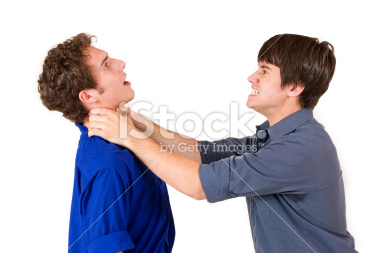

In [74]:
img = open_image(test_pics/os.listdir(test_pics)[5])
h,w = img.size
img#, h, w

In [75]:
if w % 2 != 0:
    w += 1
if h % 2 != 0:
    h += 1

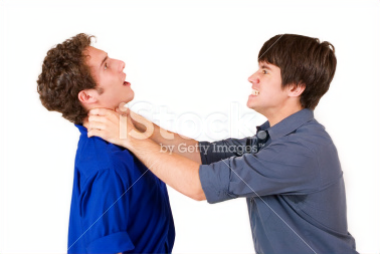

In [76]:
learn.data = get_data(1,(h,w))
learn.predict(img)[0]

In [ ]:
??save_preds

In [ ]:
my_prediction = learn.predict(img)[0]

In [ ]:
my_prediction.save(PATH/"test.png")

Inference Learner

In [61]:
PATH/'models'

PosixPath('data/gan_project/models')

In [65]:
test = load_learner(PATH/'models', 'export.pkl')

EOFError: Ran out of input